In [2]:
import pandas as pd

df = pd.read_csv('../data/processed/cleaned_dataset.csv')


C:\Users\THINKPAD\AppData\Local\Temp\ipykernel_12980\3510397147.py:3: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/cleaned_dataset.csv')


In [3]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618174 entries, 0 to 618173
Data columns (total 54 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   UnderwrittenCoverID       618174 non-null  int64  
 1   PolicyID                  618174 non-null  int64  
 2   TransactionMonth          618174 non-null  object 
 3   IsVATRegistered           618174 non-null  bool   
 4   Citizenship               618174 non-null  object 
 5   LegalType                 618174 non-null  object 
 6   Title                     618174 non-null  object 
 7   Language                  618174 non-null  object 
 8   Bank                      618174 non-null  object 
 9   AccountType               618174 non-null  object 
 10  MaritalStatus             618174 non-null  object 
 11  Gender                    618174 non-null  object 
 12  Country                   618174 non-null  object 
 13  Province                  618174 non-null  o

Define Key Metrics

Claim Frequency = proportion of policies with at least one claim

In [4]:
df['HasClaim'] = df['TotalClaims'] > 0

Claim Severity = average claim amount, for policies with a claim

In [5]:
df['ClaimSeverity'] = df.loc[df['HasClaim'], 'TotalClaims']

Margin = profit = TotalPremium - TotalClaims

In [6]:
df['Margin'] = df['TotalPremium'] - df['TotalClaims']

I have four key hypotheses to test

| H₀                                                 | KPI                                   | Feature    |
| -------------------------------------------------- | ------------------------------------- | ---------- |
| No risk differences across provinces               | ClaimFrequency, ClaimSeverity         | Province   |
| No risk differences between zip codes              | ClaimFrequency, ClaimSeverity, Margin | PostalCode |
| No significant margin difference between zip codes | Margin                                | PostalCode |
| No risk difference between genders                 | ClaimFrequency, ClaimSeverity         | Gender     |


Segment Data

Province Analysis

In [7]:
province_group = df.groupby('Province').agg({
    'HasClaim':'mean',               # Claim Frequency
    'TotalClaims': lambda x: x[x>0].mean(),  # Claim Severity
    'Margin':'mean'
}).reset_index()


Gender Analysis

In [8]:
gender_group = df.groupby('Gender').agg({
    'HasClaim':'mean',
    'TotalClaims': lambda x: x[x>0].mean(),
    'Margin':'mean'
}).reset_index()


Zip Code Analysis

Only select top zip codes with enough records ( >100 policies) to avoid noise

In [9]:
zip_counts = df['PostalCode'].value_counts()
valid_zips = zip_counts[zip_counts>100].index
zip_group = df[df['PostalCode'].isin(valid_zips)].groupby('PostalCode').agg({
    'HasClaim':'mean',
    'TotalClaims': lambda x: x[x>0].mean(),
    'Margin':'mean'
}).reset_index()


Province vs ClaimSeverity

In [10]:
from scipy import stats

# Only claims > 0
severity_groups = [group['TotalClaims'].values for name, group in df[df['HasClaim']].groupby('Province')]
f_stat, p_val = stats.f_oneway(*severity_groups)
print(f"F-statistic: {f_stat}, p-value: {p_val}")


F-statistic: 4.812609680145008, p-value: 6.7238630263519155e-06


Gender vs ClaimFrequency

In [11]:
contingency_table = pd.crosstab(df['Gender'], df['HasClaim'])
chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-square: {chi2}, p-value: {p_val}")


Chi-square: 1.9959778697508759, p-value: 0.5732419322541673


C:\Users\THINKPAD\AppData\Local\Temp\ipykernel_12980\2591487850.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


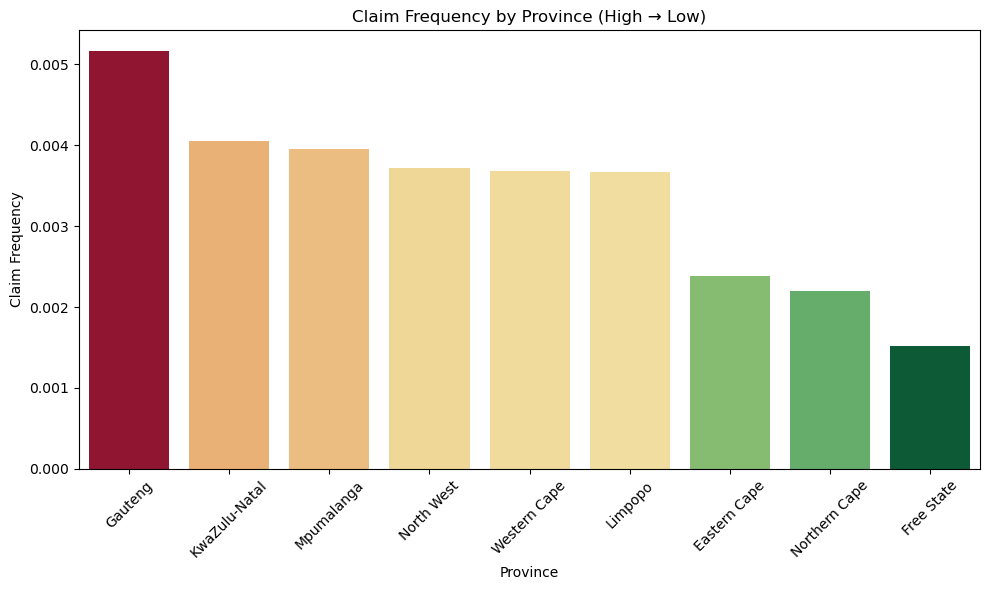

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate claim frequency by province
province_claims = df.groupby("Province")["HasClaim"].mean().sort_values(ascending=False).reset_index()

# Normalize claim frequency to 0-1 for color mapping
norm = (province_claims["HasClaim"] - province_claims["HasClaim"].min()) / \
       (province_claims["HasClaim"].max() - province_claims["HasClaim"].min())

# Create color list: high = red, low = green
colors = [plt.cm.RdYlGn(1 - v) for v in norm]  # invert to get high=red, low=green

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    x="Province",
    y="HasClaim",
    data=province_claims,
    palette=colors
)
plt.title("Claim Frequency by Province (High → Low)")
plt.ylabel("Claim Frequency")
plt.xlabel("Province")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Loss Ratio by VehicleType

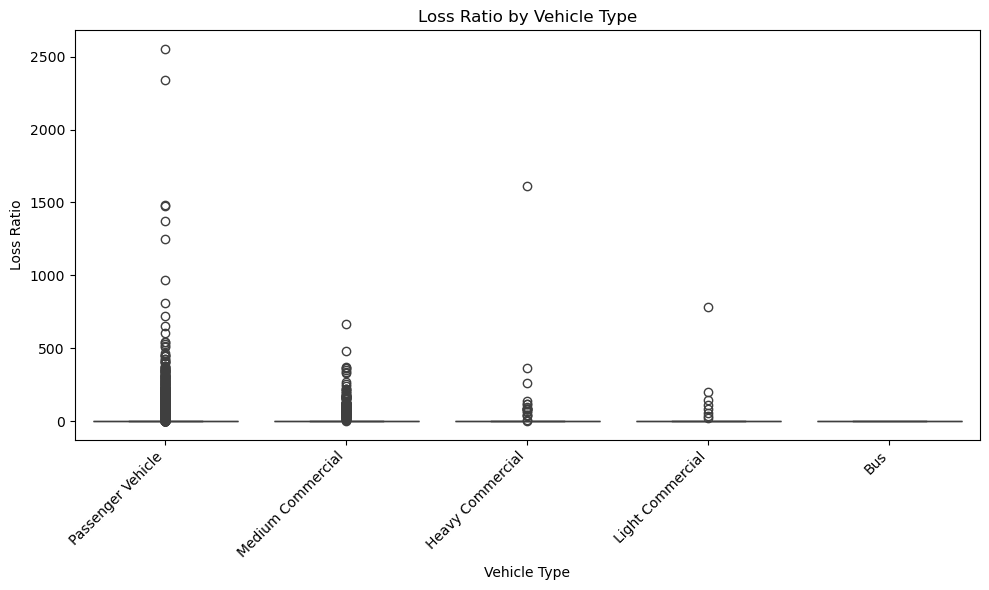

In [20]:
plt.figure(figsize=(10,6))
sns.boxplot(x='VehicleType', y='LossRatio', data=df)
plt.xticks(rotation=45, ha='right')
plt.title("Loss Ratio by Vehicle Type")
plt.ylabel("Loss Ratio")
plt.xlabel("Vehicle Type")
plt.tight_layout()
plt.show()


Claim Severity Distribution

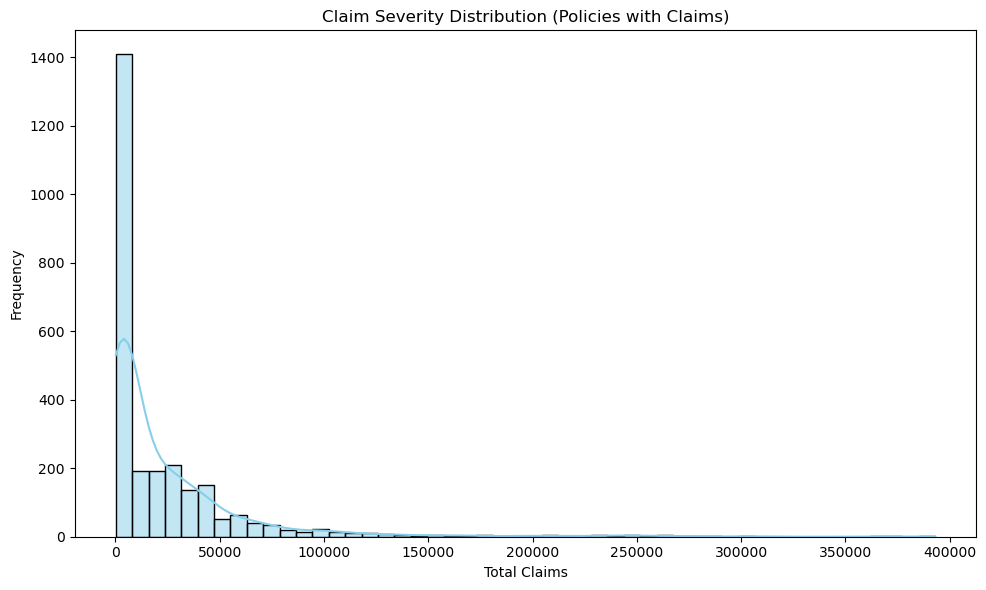

In [21]:
plt.figure(figsize=(10,6))
sns.histplot(df[df['HasClaim']==1]['TotalClaims'], bins=50, kde=True, color='skyblue')
plt.title("Claim Severity Distribution (Policies with Claims)")
plt.xlabel("Total Claims")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


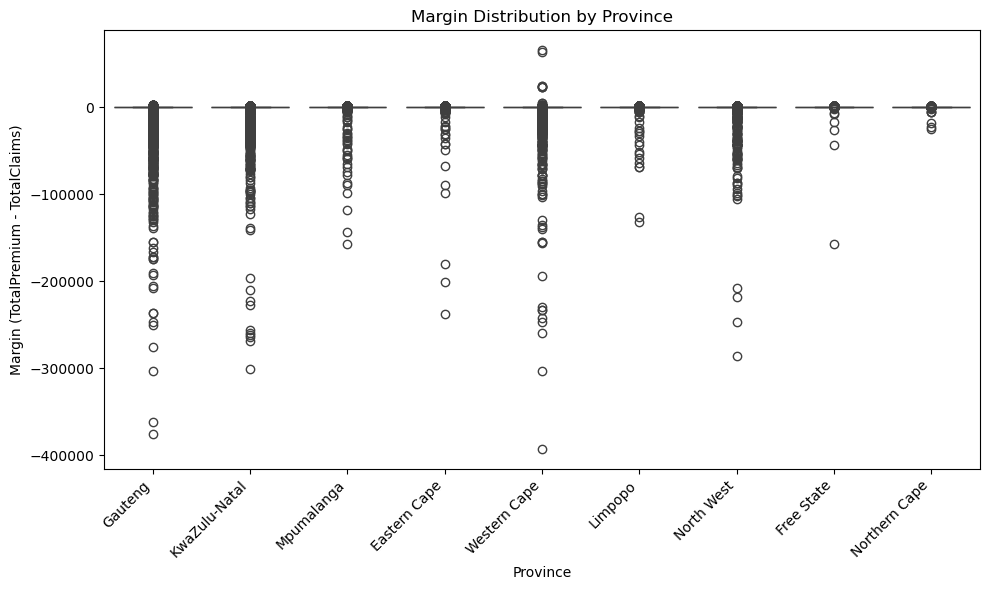

In [22]:
df['Margin'] = df['TotalPremium'] - df['TotalClaims']

plt.figure(figsize=(10,6))
sns.boxplot(x='Province', y='Margin', data=df)
plt.xticks(rotation=45, ha='right')
plt.title("Margin Distribution by Province")
plt.ylabel("Margin (TotalPremium - TotalClaims)")
plt.xlabel("Province")
plt.tight_layout()
plt.show()
